In [ ]:
!unzip qvit\ code.zip

Archive:  qvit code.zip
   creating: data/MNIST/
   creating: data/MNIST/raw/
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/t10k-labels-idx1-ubyte  
 extracting: data/MNIST/raw/t10k-labels-idx1-ubyte.gz  
  inflating: data/MNIST/raw/train-images-idx3-ubyte  
  inflating: data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte  
  inflating: data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: qvit.ipynb              
  inflating: QViT/__init__.py        
   creating: QViT/__pycache__/
  inflating: QViT/__pycache__/__init__.cpython-311.pyc  
  inflating: QViT/__pycache__/circuits.cpython-311.pyc  
  inflating: QViT/__pycache__/ml_functions.cpython-311.pyc  
  inflating: QViT/__pycache__/model.cpython-311.pyc  
  inflating: QViT/__pycache__/parametrizations.cpython-311.pyc  
  inflating: QViT/__pycache__/visual.cpython-311.pyc  
  inflating: QViT/circuits

In [ ]:
!pip install tensorcircuit
!pip install pennylane
!pip install -U qiskit
!pip install -U cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import math
from tqdm.notebook import tqdm
import time
from torchvision.datasets import MNIST #importing dataset called MNIST
from torchvision import transforms
import h5py
from QViT import *
#from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

torch.set_default_dtype(torch.float32)
torch.set_num_threads(8)
device='cpu' # technically algorithm can be run on cpu but for speed reasons, it is not suggested.

## Models

In [ ]:
mnist_trainset = MNIST(root='./data', train=True, download=True)
n,d= 7,28

transform = transforms.Compose([ transforms.Resize((14,14)), transforms.ConvertImageDtype(torch.float64),transforms.Normalize(0,1)])
data = mnist_trainset.data  # size = (60000, 28, 28_)
data = transform(data)      # size = (60000, 14, 14)
data_patched = patcher(data,[2,14])

mnist_trainset = simple_dataset(data_patched,mnist_trainset.targets)
tr_len = 4000
val_len = 1000
tr_set,val_set,test_set = torch.utils.data.random_split(mnist_trainset,[tr_len,val_len,mnist_trainset.target.shape[0]-tr_len-val_len])
tr_dl = DataLoader(tr_set,batch_size=32,shuffle=True)
val_dl = DataLoader(val_set,batch_size=32,shuffle=True)

In [ ]:
transformer_dims = {'Token_Dim':data_patched.shape[-2],'Image_Dim':data_patched.shape[-1]}
transformer_hyper = {'n_layers':2,'FC_layers':[10],
                    'head_dimension':8,'Embed_Dim': 16,'ff_dim':32}
transformer_type = {'classifying_type':'max','pos_embedding':True}

## Initialization

In [ ]:
# initialized models
classical_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='classic').to(device)
hybrid2_model = HViT(**transformer_dims,**transformer_hyper,**transformer_type,attention_type='hybrid2').to(device)

# set reset_classical and reset_hybrid2 to true after the Training section is done and after the files are created
# DO NOT run training if this is set to false and the training data already exists!!!

In [ ]:
# history
# this basically just loads the trained model. If we already have a trained model, we do not need to train it again
# but if we do not, then this part just sets it to false and trains it.
reset_classical=True
reset_hybrid2=True
#If reset_hybrid2 is True, start training the hybrid model from scratch, otherwise load the pre-trained model
if reset_classical:
    classical_history=None
#Check if the classical model needs to be reset (retrained) or loaded from pre-trained files
else:
    classical_history=torch.load('classical history')
    classical_model.load_state_dict(torch.load('classical state dict'))
# Check if the hybrid model needs to be reset (retrained) or loaded from pre-trained files
if reset_hybrid2:
    hybrid2_history=None
else:
    hybrid2_history=torch.load('hybrid2 history')
    hybrid2_model.load_state_dict(torch.load('hybrid2 state dict'))

## Training

In [ ]:
# we are using something called the Adam optimizer
# we are passing
classical_optim = torch.optim.Adam(classical_model.parameters(),lr=1e-3)
hybrid2_optim = torch.optim.Adam(hybrid2_model.parameters(),lr=1e-3)
n_epochs = 80
loss_fn = nn.CrossEntropyLoss(reduction='none')

In [ ]:
# classical training
classical_history = train(classical_model,tr_dl,val_dl,loss_fn,classical_optim,n_epochs,
                          history=classical_history,save_path="classical state dict",device=device)
torch.save(classical_history, "classical history")

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
# hybrid2 training
hybrid2_history = train(hybrid2_model,tr_dl,val_dl,loss_fn,hybrid2_optim,n_epochs,
                        history=hybrid2_history,save_path='hybrid2 state dict',device=device)
torch.save(hybrid2_history, 'hybrid2 history')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

## Plotting

"\nplt.figure()\nplt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),\n          vmin=0,vmax=1)\nplt.colorbar()\nplt.title('The normalized confusion matrix')\nprint(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')\n"

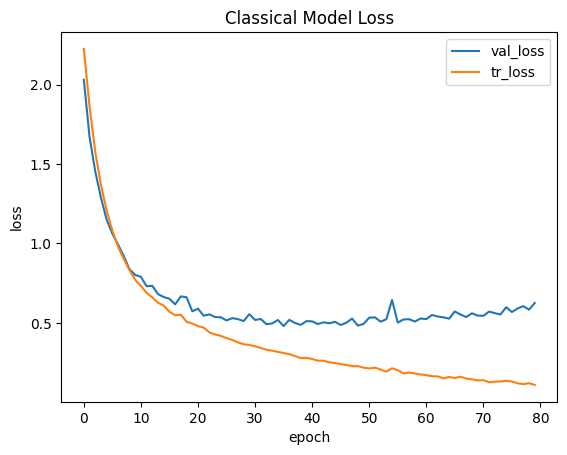

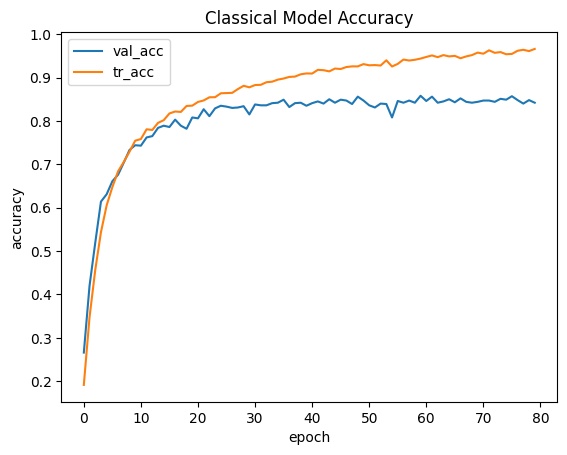

In [ ]:
#model(data_patched[[0]].to(device))
#print(f'# of parameters: {sum([np.prod(i.shape) for i in model.parameters()])}')
#model.load_state_dict(torch.load('best_state_on_training_acc'))


# Creating the plot for the classical model loss
plt.plot(classical_history['val'],label='val_loss')
plt.plot(classical_history['tr'],label='tr_loss')
plt.title('Classical Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# Creating the plot for the classical model accuracy
plt.figure()
plt.plot(classical_history['val_acc'],label='val_acc')
plt.plot(classical_history['tr_acc'],label='tr_acc')
plt.title('Classical Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

#pred = model(test_set.dataset.data[test_set.indices[:1000]].to(device)).cpu().argmax(axis=1)
"""
plt.figure()
plt.imshow(confusion_matrix(pred.cpu(),test_set.dataset.target[test_set.indices[:1000]],normalize='true'),
          vmin=0,vmax=1)
plt.colorbar()
plt.title('The normalized confusion matrix')
print(f'Wrongly Predicted Ratio:{ (pred != test_set.dataset.target[test_set.indices[:1000]]).sum()/pred.shape[0]}')
"""

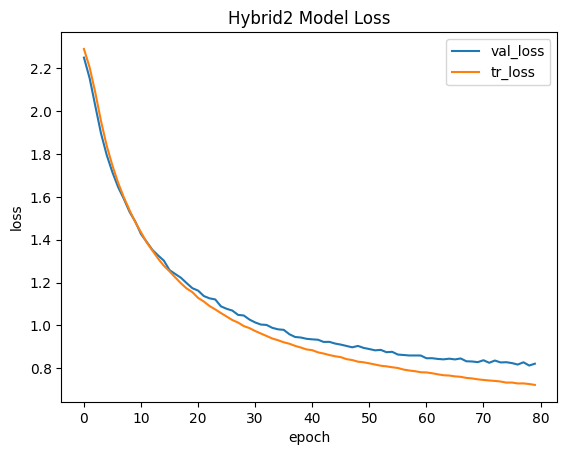

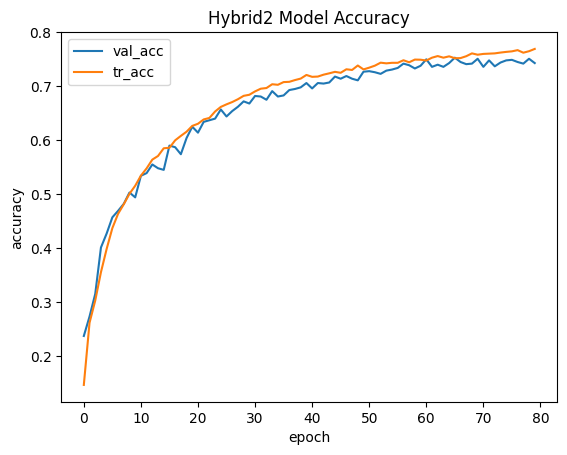

In [ ]:

# Creating the plot for the hybrid model loss
plt.plot(hybrid2_history['val'],label='val_loss')
plt.plot(hybrid2_history['tr'],label='tr_loss')
plt.title('Hybrid2 Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

# Creating the plot for the hybrid model accuracy
plt.figure()
plt.plot(hybrid2_history['val_acc'],label='val_acc')
plt.plot(hybrid2_history['tr_acc'],label='tr_acc')
plt.title('Hybrid2 Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

## Proof of concept

In [ ]:
data[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0196, 0.0588, 0.1176, 0.1686, 0.3020,
         0.2706, 0.3961, 0.3137, 0.0275, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0941, 0.4824, 0.6706, 0.8039, 0.8588, 0.8706,
         0.5412, 0.5333, 0.3020, 0.0196, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.8157, 0.8588, 0.4824, 0.5255,
         0.1255, 0.0314, 0.0118, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0039, 0.0588, 0.3608, 0.6745, 0.0980, 0.0353,
         0.0078, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.5725, 0.4863, 0.1765,
         0.0118, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.1608, 0.6078, 0.7059,
  

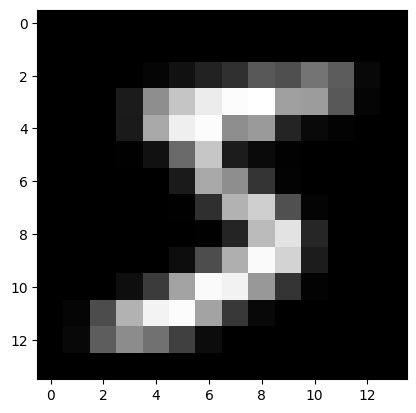

In [ ]:
plt.imshow(data[0], cmap='gray')

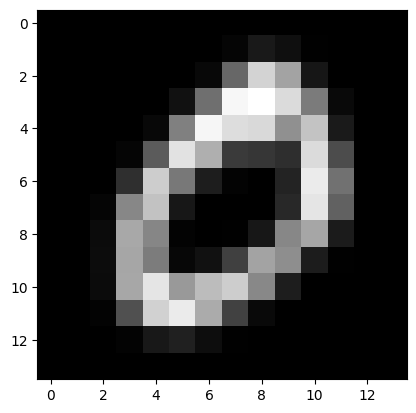

In [ ]:
plt.imshow(data[1], cmap='gray')

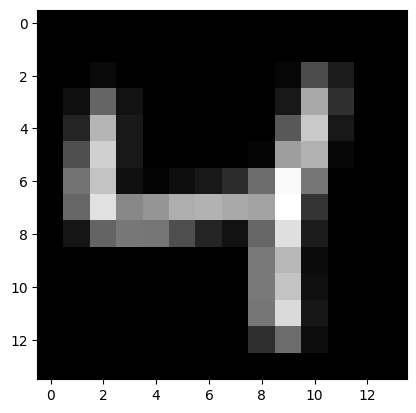

In [ ]:
plt.imshow(data[2], cmap='gray')

In [ ]:
softmax = torch.nn.Softmax()

In [ ]:
def predict(model, data_point):
    pred_probs = softmax(model(data_point))
    return pred_probs

In [ ]:
predict(classical_model, data_patched[0])

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[2.5507e-12, 9.1937e-13, 1.2113e-04, 7.4346e-04, 3.4106e-09, 9.9911e-01,
         2.9539e-09, 7.4080e-08, 2.6419e-05, 2.0490e-11]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
softmax(classical_model(data_patched[0]))

tensor([[2.5507e-12, 9.1937e-13, 1.2113e-04, 7.4346e-04, 3.4106e-09, 9.9911e-01,
         2.9539e-09, 7.4080e-08, 2.6419e-05, 2.0490e-11]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
softmax(hybrid2_model(data_patched[0]).squeeze())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([3.7828e-02, 2.8050e-04, 9.2453e-02, 1.7642e-01, 4.0498e-04, 5.0543e-01,
        2.4122e-03, 1.8359e-02, 1.5665e-01, 9.7648e-03],
       grad_fn=<SoftmaxBackward0>)